# Reddit suicide and depression analysis, part 2

In [2]:
# Import the libraries

import string
import pandas as pd
#import feather
import inflect
import pkg_resources
from symspellpy import SymSpell, Verbosity
import re
import html
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import spacy
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [3]:
# New display options

pd.set_option("max_rows", 20)
pd.set_option("max_columns", None)
pd.set_option("max_colwidth", 1000)

In [4]:
# Reload the dataset

df = pd.read_csv('reddit_depression_suicidewatch.csv')

In [5]:
df.head()

,text,label
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I never even had a sleepover at a friend's house. My aunt was supposed to take me because that is the only way my grandparents would allow me to go. But she had things come up at work and now she cannot and I am fucking devastated and lonely. I do not have any friends just my boyfriend. But he has a few friends, seems to have a good time and I do not want to ruin his vacation by being negative, expecting to be on his phone and talk to me but I am so sad. He still has three weeks till he is back and I feel like I am about to explode. it is not even my fault that I cannot go, my grandparents think they are doing something good for me but they are ruining me. I am already drowning in depression...",depression
4,"I have been prone to depression in varying forms since I was a kid. I think I have had cycles of dysthymia since adolescence. After graduating from university, I was so worn down, feeling so much failure, that I slipped into a deep, dark depression. I felt completely alone and hopeless. All my friends were off to do amazing things and I was alone, stagnating and trying to keep my head above water. During that time I started to experience suicidal ideation and formed a plan for that ""one day"" when there was no more hope. As much as I was thinking about suicide, I was 22 and there was always a small amount of hope in the back of my mind. I got lucky and things did improve for a time, but I always cycle back into a depressive state. Fast forward, and COVID and other factors have knocked me into one of the darkest, sickest periods of my life. I am not well. I struggle every day, and I have sought help, but they do not know the depths of it. I do not believe in their ability to help me....",SuicideWatch


In [6]:
# Remove html special characters

df['text'] = df['text'].apply(lambda x: html.unescape(x) if pd.notnull(x) else x)

In [7]:
# remove punctuation
def remove_punct(text):
    txt_nopunct = "".join([char for char in text if char not in string.punctuation])
    return txt_nopunct

df['prep_txt'] = df['text'].apply(lambda x: remove_punct(x))

df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,I 17F is diagnosed with bipolar disorder I do not remember much from my childhood but my parents tell me that they were at their worst when I was born We were almost dirt poor Now that I am a teenager and in a much better financial situation middlemiddle class I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get For my 17th birthday 5 days ago I got a puppy and got my hair dyed red We also went outside to eat They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home Of course I had fun but that is just it I am having a hard time appreciating even the smallest things Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole This is a huge issue for me because if I cannot learn how to appreciate things I might just end up offing myself because I cannot just understand the value of the things around me and the people that love me I am hav...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,The clock is moving too fast I am young but I feel old very old I destroy everything that I touch and do nothing very constructive I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty I feel guilty for making her go through all these shitty times and making her life hell I live badly with it sometimes I am even having delusions about saving my loved ones I am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong It would be the straw that broke the camels back I imagine that I will have to learn to live with these conditions all my life From the bottom of my heart thank you Condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,Which one is the best Slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [8]:
# custom dictionary 
custom_dict = {
    'GF':'girlfriend',
    'BF':'boyfriend',
    'bf':'boyfriend',
    'gf':'girlfriend',
    '15,':'fifteen',
    '(21)':'twenty one',
    'hes':'he is',
    '&': 'and',
    'a&e':'accident and emergency',
    'orr': 'or',
    'rn' : 'right now',
    'ppl': 'people',
    'irl': 'In real life'
}

In [9]:
df['prep_txt'] = df.prep_txt.str.replace('[...…]','').str.split().apply(lambda x: ' '.join([custom_dict.get(e, e) for e in x]))

In [10]:
df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,I 17F is diagnosed with bipolar disorder I do not remember much from my childhood but my parents tell me that they were at their worst when I was born We were almost dirt poor Now that I am a teenager and in a much better financial situation middlemiddle class I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get For my 17th birthday 5 days ago I got a puppy and got my hair dyed red We also went outside to eat They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home Of course I had fun but that is just it I am having a hard time appreciating even the smallest things Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole This is a huge issue for me because if I cannot learn how to appreciate things I might just end up offing myself because I cannot just understand the value of the things around me and the people that love me I am hav...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,The clock is moving too fast I am young but I feel old very old I destroy everything that I touch and do nothing very constructive I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty I feel guilty for making her go through all these shitty times and making her life hell I live badly with it sometimes I am even having delusions about saving my loved ones I am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong It would be the straw that broke the camels back I imagine that I will have to learn to live with these conditions all my life From the bottom of my heart thank you Condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,Which one is the best Slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [11]:
list1 = ['M','F','%','+']
list2 = [' Male',' Female',' percent',' plus']

def convert(string):

	word_list = string.split()
	#print(word_list)

	for k in range(0,len(word_list)):
		#print(k)
		l = list(word_list[k])[-1]
		#print(l)

		if l in list1:
			#print(l)
			j = list2[list1.index(l)]
			word_list[k] = word_list[k].replace(l, j)



	string = ' '.join(word_list)
		
	return string

In [12]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:convert(x))

In [13]:
df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,I 17 Female is diagnosed with bipolar disorder I do not remember much from my childhood but my parents tell me that they were at their worst when I was born We were almost dirt poor Now that I am a teenager and in a much better financial situation middlemiddle class I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get For my 17th birthday 5 days ago I got a puppy and got my hair dyed red We also went outside to eat They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home Of course I had fun but that is just it I am having a hard time appreciating even the smallest things Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole This is a huge issue for me because if I cannot learn how to appreciate things I might just end up offing myself because I cannot just understand the value of the things around me and the people that love me I ...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,The clock is moving too fast I am young but I feel old very old I destroy everything that I touch and do nothing very constructive I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty I feel guilty for making her go through all these shitty times and making her life hell I live badly with it sometimes I am even having delusions about saving my loved ones I am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong It would be the straw that broke the camels back I imagine that I will have to learn to live with these conditions all my life From the bottom of my heart thank you Condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,Which one is the best Slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [14]:
# From here, create a new column 

In [15]:
# lowercase text

df['prep_txt'] = df['prep_txt'].str.lower()

df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i 17 female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middlemiddle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my 17th birthday 5 days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy 17th birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an asshole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people that love me i ...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [16]:
df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i 17 female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middlemiddle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my 17th birthday 5 days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy 17th birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an asshole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people that love me i ...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [17]:
# convert digits to words 

inflector = inflect.engine()

def convert_num_to_words(utterance):
    utterance = ' '.join([inflector.number_to_words(i) if i.isdigit() else i for i in utterance.split()])
    return utterance

In [18]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:convert_num_to_words(x))

In [19]:
df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i seventeen female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middlemiddle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my 17th birthday five days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy 17th birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an asshole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people that ...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

## Spell Check Using SymSpell

In [20]:
# Run SymSpell 
sym_spell = SymSpell()

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")


In [21]:
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)


True

In [22]:
def spellchecker(text):
    correct_spelling = []
    for token in text.split(" "):
        x = sym_spell.lookup_compound(token, max_edit_distance=2)[0].__str__()
        y = x.split(',')[0]
        correct_spelling.append(y)
    return " ".join(correct_spelling)

In [23]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:spellchecker(x))

In [24]:
df.head()

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i seventeen female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middle middle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my with birthday five days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy with birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an ass hole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people tha...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I 

In [25]:
# save dataset
df.to_csv(r'reddit_clf_corrected.csv', index = False)

## Word Cloud

In [26]:
# create depression and SuicideWatch variables
depression =  df['prep_txt'][df['label']=='depression']
SuicideWatch = df['prep_txt'][df['label']=='SuicideWatch']

In [27]:
depression.head()

1                                                                                                                                                                                                                                                         the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you conde

In [28]:
SuicideWatch.head()

0    i seventeen female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middle middle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my with birthday five days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy with birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an ass hole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people th

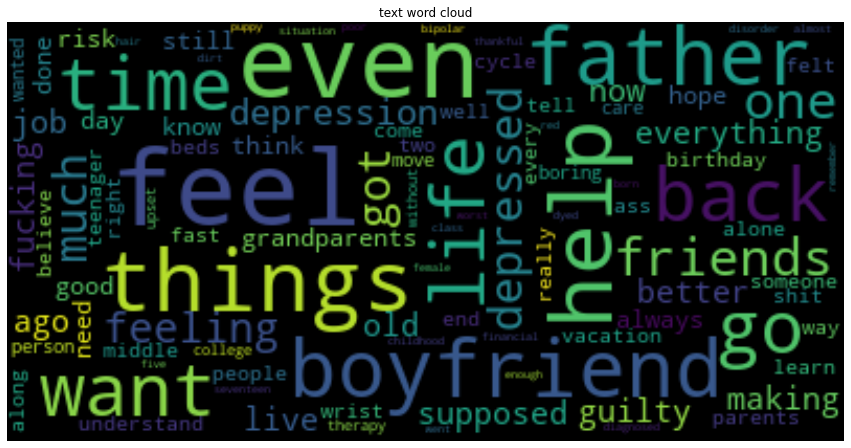

In [29]:
# Create and generate a word cloud image

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(str(df['prep_txt']))

# Display the image

plt.subplots(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("text word cloud")
plt.show()

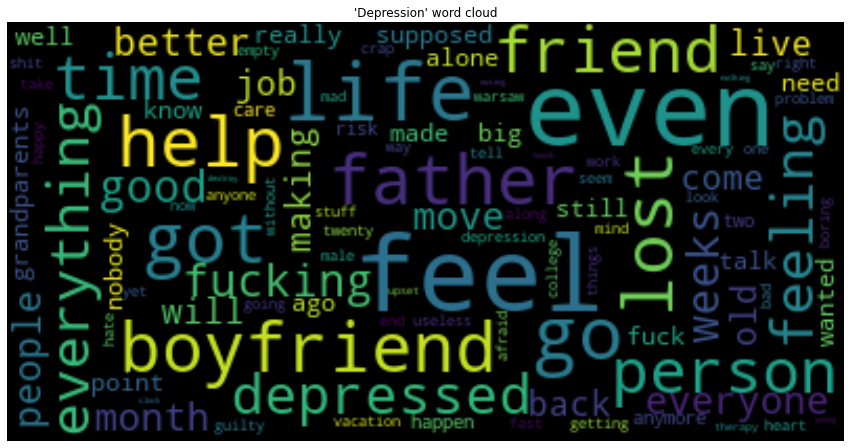

In [30]:
# Create and generate a word cloud image

wordcloud_depression = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(str(depression))

# Display the image

plt.subplots(figsize=(15,15))
plt.imshow(wordcloud_depression, interpolation='bilinear')
plt.axis("off")
plt.title("'Depression' word cloud")
plt.show()

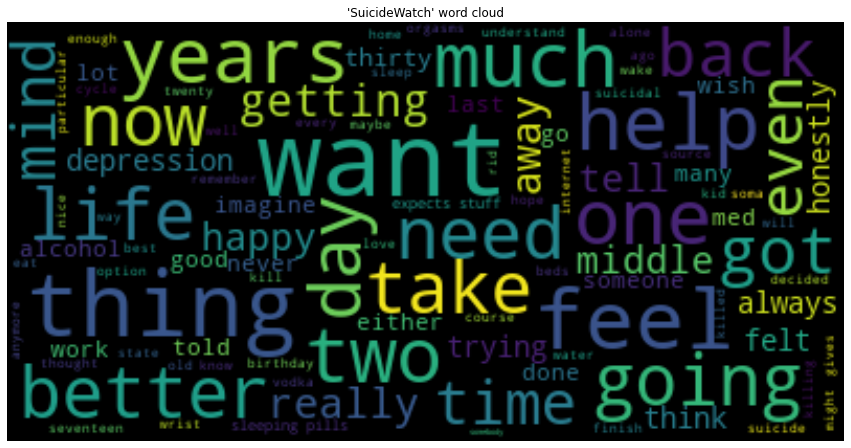

In [31]:
# Create and generate a word cloud image

wordcloud_suicide = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(str(SuicideWatch))

# Display the image

plt.subplots(figsize=(15,15))
plt.imshow(wordcloud_suicide, interpolation='bilinear')
plt.axis("off")
plt.title("'SuicideWatch' word cloud")
plt.show()

In [32]:
# Save the images
wordcloud.to_file("text_wordcloud.png")
wordcloud_suicide.to_file("suicidewatch_wordcloud.png")
wordcloud_depression.to_file("depression_wordcloud.png")

## Feature Engineering

In [33]:
# Create feature of post length 
df['txt_len'] = df['text'].apply(lambda x: len(x) - x.count(" "))

df.head()

,text,label,prep_txt,txt_len
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i seventeen female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middle middle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my with birthday five days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy with birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an ass hole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people tha...,1714
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned,622
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation,45
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they a

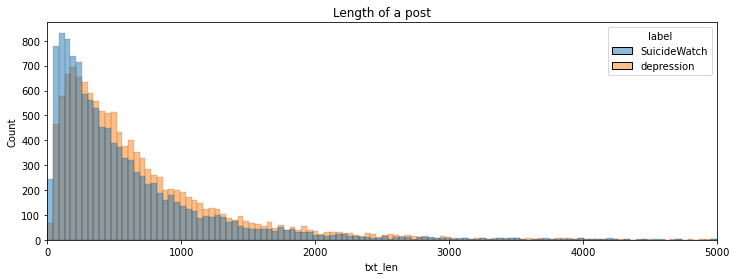

In [34]:
# visualization of distribution text length

fig,ax = plt.subplots(figsize=(12,4))
sns.histplot(data=df, x="txt_len", hue="label")
ax.set(xlim=(0, 5000))
ax.set(title="Length of a post")
plt.savefig('len_posts.png')

In [35]:
# Logarithmic transformation of post length
df['log_txt_len'] = np.log1p(df['txt_len'])

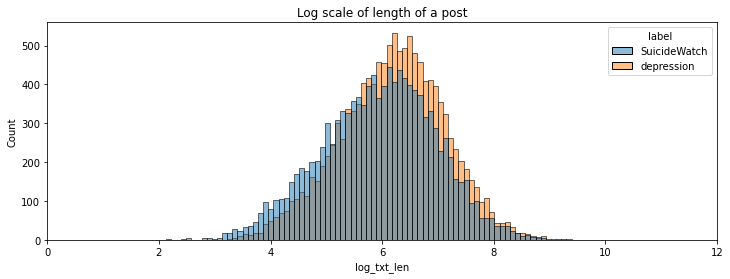

In [36]:
# visualization of distribution text length 
fig,ax = plt.subplots(figsize=(12,4))
sns.histplot(data=df, x="log_txt_len", hue="label")
ax.set(xlim=(0, 12))
ax.set(title="Log scale of length of a post")
plt.savefig('log_len_posts.png')

In [37]:
df.columns

Index(['text', 'label', 'prep_txt', 'txt_len', 'log_txt_len'], dtype='object')

In [38]:
df.head()

,text,label,prep_txt,txt_len,log_txt_len
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",SuicideWatch,i seventeen female is diagnosed with bipolar disorder i do not remember much from my childhood but my parents tell me that they were at their worst when i was born we were almost dirt poor now that i am a teenager and in a much better financial situation middle middle class i cannot help but feel guilty because i feel like i am not thankful enough for the things that i get for my with birthday five days ago i got a puppy and got my hair dyed red we also went outside to eat they bought me cake and surprised me with foil balloons saying happy with birthday when we came back home of course i had fun but that is just it i am having a hard time appreciating even the smallest things maybe it is because i am depressed and want to just dissipate into thin air but i do not want to be an ass hole this is a huge issue for me because if i cannot learn how to appreciate things i might just end up offing myself because i cannot just understand the value of the things around me and the people tha...,1714,7.447168
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",depression,the clock is moving too fast i am young but i feel old very old i destroy everything that i touch and do nothing very constructive i have someone i share my life with who has difficulty understanding how i may be feeling and i feel guilty i feel guilty for making her go through all these shitty times and making her life hell i live badly with it sometimes i am even having delusions about saving my loved ones i am afraid to come out of my depressed nest let us say to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong it would be the straw that broke the camels back i imagine that i will have to learn to live with these conditions all my life from the bottom of my heart thank you condemned,622,6.434547
2,Which one is the best? Slitting wrist or suffocation?,SuicideWatch,which one is the best slitting wrist or suffocation,45,3.828641
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old 

In [43]:
df.groupby(['label']).describe()

txt_len                                                    \
                count        mean         std  min    25%    50%    75%   
label                                                                     
SuicideWatch  11812.0  621.219015  752.297344  4.0  188.0  399.0  775.0   
depression    12567.0  735.387602  819.235008  0.0  260.0  503.0  922.5   

                      log_txt_len                                          \
                  max       count      mean       std       min       25%   
label                                                                       
SuicideWatch  17282.0     11812.0  5.934917  1.028667  1.609438  5.241747   
depression    22917.0     12567.0  6.181589  0.936559  0.000000  5.564520   

                                             
                   50%       75%        max  
label                                        
SuicideWatch  5.991465  6.654153   9.757479  
depression    6.222576  6.828171  10.039678

## Final Text Cleaning and lemmatization

In [80]:
df = df = pd.read_csv('reddit_clf_corrected.csv')

In [81]:
from nltk.corpus import stopwords

In [82]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [83]:
print(len(stopwords.words('english')))

179


In [84]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such','only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just']

In [85]:
len(stop_words)

128

In [86]:
nltk.download('wordnet')
lemetizer = WordNetLemmatizer()
ps = PorterStemmer()

[nltk_data] Downloading package wordnet to /Users/sumit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
def lemmatizing(text):
    text = re.sub(r'\d+', '', str(text))
    text = text.split()
    
    text = [ps.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

In [88]:
df['prep_txt'] = df['prep_txt'].apply(lambda x: lemmatizing(x))

In [96]:
df

,text,label,prep_txt
0,"I (17F) is diagnosed with bipolar disorder. I do not remember much from my childhood but my parents tell me that they were at their worst when I was born. We were almost dirt poor. Now that I am a teenager and in a much better financial situation (middle-middle class), I cannot help but feel guilty because I feel like I am not thankful enough for the things that I get. For my 17th birthday 5 days ago, I got a puppy and got my hair dyed red. We also went outside to eat. They bought me cake and surprised me with foil balloons saying Happy 17th Birthday when we came back home. Of course I had fun but that is just it. I am having a hard time appreciating even the smallest things. Maybe it is because I am depressed and want to just dissipate into thin air but I do not want to be an asshole. This is a huge issue for me because if I cannot learn how to appreciate things, I might just end up offing myself because I cannot just understand the value of the things around me and the people tha...",1,seventeen femal diagnos bipolar disord not rememb much childhood parent tell worst born almost dirt poor now teenag much better financi situat middl middl class cannot help feel guilti feel like not thank enough thing get birthday five day ago got puppi got hair dy red also went outsid eat bought cake surpris foil balloon say happi birthday came back home cours fun hard time appreci even smallest thing mayb depress want dissip thin air not want ass hole huge issu cannot learn appreci thing might end of cannot understand valu thing around peopl love hard time understand cannot find reason live anymor still feel way despit take antidepress free hospit bow go regular checkup paid father liter studi bath drink water eat breath also feed take care dog not hard not understand bless complet love famili support understand bless cute sweet littl love pet wake morn understand bless could eat three time day without ever cook someon cook understand bless abl studi prestigi univers also scholar...
1,"The clock is moving too fast, I am young but I feel old, very old. I destroy everything that I touch and do nothing very constructive. I have someone I share my life with who has difficulty understanding how I may be feeling and I feel guilty. I feel guilty for making her go through all these shitty times and making her life hell. I live badly with it, sometimes I am even having delusions about saving my loved ones. I am afraid to come out of my depressed nest, let us say; to find job or friends or even a simple feeling of normalcy would bring me satisfaction and ultimately be wrong. It would be the straw that broke the camel's back. I imagine that I will have to learn to live with these conditions all my life. From the bottom of my heart thank you. Condemned",0,clock move fast young feel old old destroy everyth touch noth construct someon share life difficulti understand may feel feel guilti feel guilti make go shitti time make life hell live badli sometim even delus save love one afraid come depress nest let us say find job friend even simpl feel normalci would bring satisfact ultim wrong would straw broke camel back imagin learn live condit life bottom heart thank condemn
2,Which one is the best? Slitting wrist or suffocation?,1,one best slit wrist suffoc
3,"So my boyfriend is on vacation and I was supposed to go with him. I planned everything what I would fucking wear everyday and shit. He was really excited about me coming along as well, I was supposed to meet his parents. I am 19 years old and I live with my grandparents. they are so strict that I never even had a sleepover at a friend's house. My aunt was supposed to take me because that is the only way my grandparents would allow me to go. But she had things come up at work and now she cannot and I am fucking devastated and lonely. I do not have any friends just my boyfriend. But he has a few friends, seems to have a good time and I do not want to ruin his vacation by being nega

## Vectorization

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [95]:
df['label'].replace({'depression': 0, 'SuicideWatch': 1},inplace=True)

In [98]:
label = df['label']
label

0        1
1        0
2        1
3        0
4        1
        ..
24374    1
24375    0
24376    1
24377    0
24378    0
Name: label, Length: 24379, dtype: int64

In [100]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(df['prep_txt'])
X = tfidf_vectorizer.transform(df['prep_txt'])
X_test = tfidf_vectorizer.transform(df['prep_txt'])

X_train, X_val, y_train, y_val = train_test_split(
    X, label, train_size = 0.75
)

## Model training

In [102]:
lr = LogisticRegression(C=0.5)
lr.fit(X_train, y_train)

LogisticRegression(C=0.5)

In [103]:
print ("Accuracy ", accuracy_score(y_val, lr.predict(X_val)))

Accuracy  0.7297785069729287
